## Семинар 10: "Генерация текстов"

ФИО: 

In [4]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [21]:
! head -n 2 author-quote.txt

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [22]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

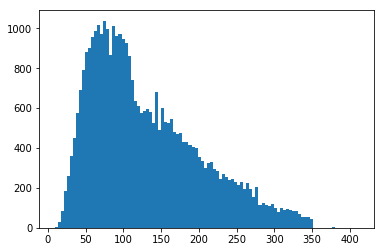

In [23]:
lines_len = []
for l in map(len, lines):
    lines_len.append(l)

plt.hist(lines_len, bins=100);

In [24]:
line = lines[0]

In [25]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [26]:
lines = [l for l in filter(lambda x: len(x) <= 50, lines)]

In [27]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [28]:
vocab = Vocabulary(lines)

In [29]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [30]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        input = self.vocab.encode(['<go>'] + list(self.sentences[idx]))
        output = self.vocab.encode(list(self.sentences[idx])+['<eos>'])
        return input, output

In [31]:
dataset = Quotes(lines, vocab)

In [32]:
dataloader = DataLoader(dataset, shuffle=True)

### Часть 2: определение модели

In [55]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
    
    def forward(self, input):
        embedding = self.embedding(input)
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        output, _ = self.generator(embedding, (h))
        classes = self.classifier(output[0])
        return classes
    
    def generate(self, vocab, max_len=100):
        # TODO: replace with sampling
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            new_token_id = np.argmax(classes.data.numpy()) # <- here
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [56]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [57]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.01)

In [58]:
criterion = nn.CrossEntropyLoss()

In [59]:
losses = []

In [66]:
for epoch in range(1000):
    #bar = progressbar.ProgressBar()
    
    for i, (batch, target) in enumerate(dataloader):
        batch = Variable(batch)
        target = Variable(target, requires_grad=False)[0]
        prediction = oracle(batch.long())
        loss = criterion(prediction, target.long())
        loss.backward()
        if i%32 == 0: # aka batch
            optimizer.step()
            oracle.zero_grad()
            losses.append(loss.data[0])
            print (loss.data[0], oracle.generate(vocab))

torch.Size([32])
3.1460938453674316 I e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e 
torch.Size([48])
torch.Size([42])
torch.Size([47])
torch.Size([45])
torch.Size([46])
torch.Size([45])
torch.Size([34])
torch.Size([41])
torch.Size([49])
torch.Size([32])
torch.Size([20])
torch.Size([51])
torch.Size([49])
torch.Size([40])
torch.Size([34])
torch.Size([51])
torch.Size([51])
torch.Size([49])
torch.Size([43])
torch.Size([51])
torch.Size([51])
torch.Size([27])
torch.Size([39])
torch.Size([44])
torch.Size([40])
torch.Size([30])
torch.Size([41])
torch.Size([48])
torch.Size([26])
torch.Size([42])
torch.Size([26])
torch.Size([39])
2.6698944568634033 I e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e 
torch.Size([44])
torch.Size([35])
torch.Size([50])
torch.Size([44])
torch.Size([28])
torch.Size([37])
torch.Size([31])
torch.Size([43])
torch.Size([47])
torch.Size([36])
torch.Size([43])
torch.Size([

KeyboardInterrupt: 

In [369]:
oracle.generate(vocab)

'I love the be and the what the the the the the the the the the the the the the the the the the the t'

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

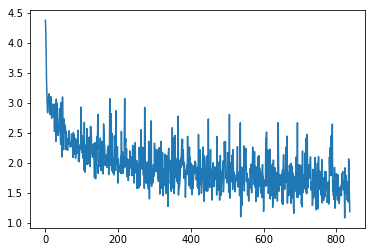

In [367]:
plt.plot(losses)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: